## Load processed data

In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import yaml
import numpy as np
import torch
from collections import Counter
from torch import nn
from torchtext import data
from matplotlib import pyplot as plt
import seaborn as sns
import torch.nn.functional as F
%matplotlib inline
import copy
import argparse
from helper import data_generator
import sys; sys.argv=['']; del sys
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
file = 'args/sst_attn_all.yaml'
with open(file) as f:
    args = yaml.load(f, Loader=yaml.Loader)
    parser = argparse.ArgumentParser(description='attention')
    config = parser.parse_args()
    for k, v in args['common'].items():
        setattr(config, k, v)

In [17]:
config.batch_size = 1024
# config.batch_size = 512#ag news
# config.batch_size = 256#imdb

In [18]:
import pickle
with open(config.dic_path, 'rb') as f:
    vocab, word2id, id2word = pickle.load(f)

In [19]:
train_dg = data_generator(config, config.train_path)
#train_eval_dg = data_generator(config, config.train_path, False)
dev_dg = data_generator(config, config.dev_path, False)
test_dg = data_generator(config, config.test_path, False)

In [20]:
train_dg.data_len

98794

## Train a model

In [21]:
from torch.nn import utils as nn_utils
import torch
from torch import optim
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.init as init
from self_defined_gru_spectral import GRU
# from self_defined_gru import GRU
from self_defined_lstm_spectral import LSTM
from self_defined_rnn_spectral import RNN
from dynamic_lstm import dynamicLSTM
from dynamic_gru import dynamicGRU
from dynamic_rnn import dynamicRNN


In [22]:
class SimpleClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, label_dim=1, rnn_type='elman'):
        super(SimpleClassifier, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        #self.embeddings.weight.data.uniform_(-0.05, 0.05)
        self.dropout = nn.Dropout(0.5)

        self.affine = nn.Linear(embed_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.scale = scale
        
        self.sigmoid = nn.Sigmoid()
        if rnn_type == 'elman':
            self.rnn = RNN(embed_dim, hidden_dim, 
                          bidirectional=False)
        elif rnn_type == 'gru':
            self.rnn = GRU(embed_dim, hidden_dim, 
                          bidirectional=False)
        else:
            self.rnn = LSTM(embed_dim, hidden_dim, 
                          bidirectional=False)
#         self.rnn = RNN(embed_dim, hidden_dim, 
#                       bidirectional=False)
        self.linear = nn.Linear(embed_dim, hidden_dim)
        self.label_dim = label_dim

        self.decoder = nn.Linear(hidden_dim, label_dim, bias=False)

    # batch_size * sent_l * dim
    def forward(self, seq_ids, seq_lengths=None):
        '''
        Args:
            seq_ids: word indexes, batch_size, max_len, Long Tensor
            seq_lengths: lengths of sentences, batch_size, Long Tensor
        attention:
            score = v h
            att = softmax(score)
        '''
        
        seq_embs = self.embeddings(seq_ids)
        seq_embs = self.dropout(seq_embs)
        #print(seq_embs.shape)
        batch_size, max_len, hidden_dim = seq_embs.size()
        # batch * max_len * hidden_states
        #hidden_vecs = self.affine(seq_embs)
        hidden_vecs, final_vec = self.rnn(seq_embs, seq_lengths)
        #final_vec = self.linear(seq_embs)
        final_vec = self.dropout(final_vec)
        senti_scores = self.decoder(final_vec)
        #multi class
        if self.label_dim == 1:
            probs = self.sigmoid(senti_scores)
        else:
            probs = self.softmax(senti_scores)
            logits = torch.log(probs + 0.000000000001)
            return logits, senti_scores
        return probs, senti_scores
    
    def load_vector(self, path, trainable=False):
        '''
        Load pre-savedd word embeddings
        '''
        with open(path, 'rb') as f:
            vectors = pickle.load(f)
            print("Loaded from {} with shape {}".format(path, vectors.shape))
            #self.word_embed.weight = nn.Parameter(torch.FloatTensor(vectors))
            np_data = torch.from_numpy(vectors)#/4
            self.embeddings.weight.data.copy_(np_data)
            self.embeddings.weight.requires_grad = trainable
            print('embeddings loaded')

In [23]:
##Evaluation classification
def evaluate_cls(dg, model, label_dim=1):
    #Make prediction
    model.eval()
    count = 0
    #record the gold and the prediction
    gold_labels = []
    pred_labels = []
    dg.reset_samples()
    while dg.index<dg.data_len:
        sent_ids, label_list, sent_lens = next(dg.get_ids_samples())
        outputs, _ =  model(sent_ids.to(device), sent_lens.to(device))
        if label_dim == 1:
            preds = (outputs>0.5).squeeze()

            gold_labels += list(label_list.cpu().numpy())
            pred_labels += list(preds.cpu().numpy())
            num = (preds.cpu() == label_list.bool()).sum().cpu().item()
        else:
            preds = outputs.argmax(1)
            num = (label_list==preds.cpu()).sum().item()
        count += num

    accuracy = count*1.0/dg.data_len
    print('Evaluation accuracy:', accuracy)
    return accuracy

#regression
def evaluate_reg(dg, model):
    #Make prediction
    model.eval()
    count = 0
    #record the gold and the prediction
    error = 0
    dg.reset_samples()
    while dg.index<dg.data_len:
        sent_ids, label_list, sent_lens = next(dg.get_ids_samples())
        probs, scores = model(sent_ids.to(device), sent_lens.to(device))
        #label_list.apply_(scale_value)
        loss = loss_func(scores.squeeze(), label_list.float().to(device))
        num = len(sent_lens)
        error += loss.item() * num
        count += num

    mse = error/count
    return mse

In [24]:
def get_weights_copy(model):
    weights_path = 'weights_temp.pt'
    torch.save(model.state_dict(), weights_path)
    return torch.load(weights_path)

## Load the model

In [54]:
# torch.manual_seed(555)
# np.random.seed(555)
import os
label_dim = 1
loss_func = nn.BCELoss()
if label_dim>1:
    loss_func = nn.NLLLoss()

path = "checkpoints/cuda1_sst_spectral_norm_gru(nobias)_20211009.pt"
if os.path.exists(path):
    best_model = torch.load(path)
else:
    #torch.manual_seed(666)
    #model = SimpleAttnClassifier(config.vocab_size, 100, 100, 1, scale)
    hidden_dim = 300
    model = SimpleClassifier(config.vocab_size, 300, hidden_dim, label_dim, 'gru')
    #model.load_vector(config.emb_path, trainable=True)
    
    model = model.to(device)
    ##################################
    ####Weight decay can influence the result, if the value is too large, the model will not converge after iterations
    #optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0.000000)
    #optimizer = optim.Adagrad(model.parameters(), lr=0.5, weight_decay=0.00000, lr_decay=0.001)
    #optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.000001, lr_decay=0.001)

    
    loop_num = int(train_dg.data_len/config.batch_size)+1
    best_model = None
    best_acc = -1
    train_acc = []
    valid_acc = []
    for i in range(15):
        print('Epoch:', i)
        print('#'*20)
        
        ##For gru
        #optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.00001, lr_decay=0.001)
        #for lstm
        #optimizer = optim.Adagrad(model.parameters(), lr=0.02, weight_decay=0.00002, lr_decay=0.0001)
        #for elman
        #optimizer = optim.Adagrad(model.parameters(), lr=0.02, weight_decay=0.00002, lr_decay=0.0001)
        #for elman
        optimizer = optim.Adagrad(model.parameters(), lr=0.02, weight_decay=0.00001, lr_decay=0.0001)

        total_loss = 0
        model.train()
        #shuffle the training set given the random seed
        train_dg.shuffle_data()
        #sequential sampling, use all the dataset
        train_dg.reset_samples()
        #model.embeddings.required_grad = config.update_emb
        for j in range(loop_num):
            model.zero_grad()
            # generate dataset
            sent_ids,  label_list, sent_lens = next(train_dg.get_sequential_ids_samples())
            probs, scores = model(sent_ids.to(device), sent_lens.to(device))
            #label_list.apply_(scale_value)
            if label_dim == 1:
                loss = loss_func(probs.squeeze(), label_list.float().to(device))#
            else:
                loss = loss_func(probs.squeeze(), label_list.to(device))
            # Do the backward pass and update the gradient
            #w_h = model.rnn.f_cell.weight_ih
            #loss += w_h.norm(2)**2*0.0001#lstm
            #loss += w_h.norm(2)**2*0.01#gru
#             if i>5:
#                 loss += w_h.norm(2)**2*0.01
            loss.backward()
#             nn.utils.clip_grad_norm_(model.parameters(),0.25)#0.05
            nn.utils.clip_grad_norm_(model.parameters(),5)
            optimizer.step()
            if j%20== 0:
                l = loss.cpu().item()
                print('Sample Loss:{:.3f}'.format(l))

        #Dev Evaluation
        #print('Training Accuracy')
        #t_acc = evaluate(train_eval_dg, model)
        #print('Dev Accuracy')
        dev_acc = evaluate_cls(dev_dg, model, label_dim)
        #train_acc.append(t_acc)
        valid_acc.append(dev_acc)
        if best_acc < dev_acc:
            best_acc = dev_acc
            best_model_dict = get_weights_copy(model)
            
        #best_model = model
#     #Test performance
#     print('Training Accuracy')
#     t_acc = evaluate(train_eval_dg, model)
    best_model = copy.copy(model)
    best_model.load_state_dict(best_model_dict)
    #del best_model_dict
    print('Best dev:', round(best_acc,4))
    test_acc = evaluate_cls(test_dg, best_model, label_dim)
    #Test performance       
    print('Scale', scale, 'Test ACC:', round(test_acc,4))
#     score_list = []
#     for neg_phrase in negation_phrases_filtered:
#         v = get_phrase_polarity(neg_phrase, best_model, hidden_dim)
#         score_list.append(v)
#     neg_phrase_scores.append(score_list)
    

In [55]:
###newnew

#best_model = torch.load("checkpoints/cuda1_sst_spectral_norm_gru(nobias)_20211009.pt")
#best_model = torch.load("checkpoints/cuda1_sst_spectral_norm_gru(nobias)_20220503.pt")
#torch.save(best_model, "checkpoints/cuda1_sst_spectral_norm_gru(nobias)_20220503.pt")

In [56]:
# #print('Best dev:', best_acc)
# scale = 10
# label_dim=4
# # best_model = copy.copy(model)
# # best_model.load_state_dict(best_model_dict)
# valid_acc = evaluate_cls(dev_dg, best_model.to(device),label_dim)
# test_acc = evaluate_cls(test_dg, best_model.to(device),label_dim)
# #Test performance       
# print('valid acc:', round(valid_acc*100,2), 'Test ACC:', round(test_acc*100,2))

In [57]:
from all_ngram_feature import *

## Extract positive and negative adjectives
Let us do an experiment, check whether the labels have strong relationship with certain words like the sentiment indicator "good", "bad"

In [58]:
texts, labels = zip(*train_dg.data_batch)
text_length = [len(t) for t in texts]

In [59]:
texts2, labels2 = zip(*dev_dg.data_batch)
text_length2 = [len(t) for t in texts2]

In [60]:
texts3, labels3 = zip(*test_dg.data_batch)
text_length3 = [len(t) for t in texts3]

In [61]:
#Calculate the times that a token appears in a specified label

In [62]:
word_label_pair = []
word_doc_freq = {}
vocab = []
for i, text in enumerate(texts):
    for w in text:
        word_doc_freq[w] = word_doc_freq.get(w, 0) + 1
        
for i, text in enumerate(texts):
    label = labels[i]
    for w in text:
        word_doc_freq[w] = word_doc_freq.get(w, 0) + 1
    word_label_pair += [(id2word[item], label) for item in text]
    vocab += [id2word[item] for item in text]
vocab = set(vocab)

In [63]:
word_label_pair_freq = Counter(word_label_pair)
#Get the ratio, a word appears in positive sentences: a word appears in negative sentences
token_freq_pos = {}
token_freq_neg = {}
pos_tokens = []
neg_tokens = []
neutral_tokens = []
total_diff_freq = 0
#Note here, 1 means positive and 0 means negative
for w in vocab:
    freq_pos = word_label_pair_freq[(w, 1)]
    freq_neg = word_label_pair_freq[(w, 0)]
    token_freq_pos[word2id[w]] = freq_pos
    token_freq_neg[word2id[w]] = freq_neg
    if freq_pos+freq_neg == 0:
        continue

    if freq_pos-freq_neg !=0:
        #We use 10
        rate = (freq_pos-freq_neg)/(freq_pos+freq_neg)*1.0
        if rate>0.5 and freq_pos>5:#positive tokens
            pos_tokens.append(w)
        if rate<-0.5 and freq_neg>5:
            neg_tokens.append(w)

    if abs(freq_pos-freq_neg)/(freq_pos+freq_neg)<0.1 and abs(freq_pos-freq_neg)<5:
        neutral_tokens.append(w)
#     if freq_pos-freq_neg !=0:
#         #We use 10
#         rate = (freq_pos-freq_neg)/(freq_pos+freq_neg)*1.0
#         if freq_pos-freq_neg>20:#positive tokens
#             pos_tokens.append(w)
#         if freq_neg-freq_pos>20:
#             neg_tokens.append(w)

#     if abs(freq_pos-freq_neg)<5:
#         neutral_tokens.append(w)

In [64]:
#print(neutral_tokens)

In [65]:
from textblob import TextBlob
pos_tokens_selected = []
neg_tokens_selected = []
for w in pos_tokens:
    s = TextBlob(w)
    if len(s.tags) == 0:
        continue
    if s.polarity>0.2 and s.tags[0][1]=='JJ':
        pos_tokens_selected.append(w)
for w in neg_tokens:
    s = TextBlob(w)
    if len(s.tags) == 0:
        continue
    if s.polarity<-0.2 and s.tags[0][1]=='JJ':
        neg_tokens_selected.append(w)        

In [66]:
len(pos_tokens_selected)

73

In [67]:

# phi, scores = get_higher_degree_ngram(inputs, best_model, degree=1, hidden_dim=300)
# scores

In [68]:
pos_tokens_index = [word2id[w] for w in pos_tokens]
neg_tokens_index = [word2id[w] for w in neg_tokens]
neutral_tokens_index = [word2id[w] for w in neutral_tokens]
pos_tokens_index_label1 = [token_freq_pos[w] for w in pos_tokens_index]
pos_tokens_index_label0 = [token_freq_neg[w] for w in pos_tokens_index]
pos_tokens_index_diff = [token_freq_pos[w]-token_freq_neg[w] for w in pos_tokens_index]

neg_tokens_index_label1 = [token_freq_pos[w] for w in pos_tokens_index]
neg_tokens_index_label0 = [token_freq_neg[w] for w in pos_tokens_index]
neg_tokens_index_diff = [token_freq_pos[w]-token_freq_neg[w] for w in neg_tokens_index]

## Visualizing negation

In [69]:
hidden_dim = 300
pos_token_ps = []
negation_pos_token_ps = []
neg_token_ps = []
negation_neg_token_ps = []
negation_id = word2id['not']
rnn_cell = 'gru'
if rnn_cell == 'gru':
    get_polarity = gru_phrase_polarity_new
if rnn_cell == 'lstm':
    get_polarity = lstm_phrase_polarity_new
if rnn_cell == 'elman':
    get_polarity = rnn_phrase_polarity_new

for w in pos_tokens_selected:
    bigram = [negation_id] + [word2id[w]]
    score1 = get_polarity([word2id[w]], best_model.to(device), hidden_dim)
    score2 = get_polarity(bigram, best_model.to(device), hidden_dim)
    pos_token_ps.append(score1)
    negation_pos_token_ps.append(score2)
for w in neg_tokens_selected:
    bigram = [negation_id] + [word2id[w]]
    score1 = get_polarity([word2id[w]], best_model, hidden_dim)
    score2 = get_polarity(bigram, best_model, hidden_dim)
    neg_token_ps.append(score1)
    negation_neg_token_ps.append(score2)

/home/richard/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


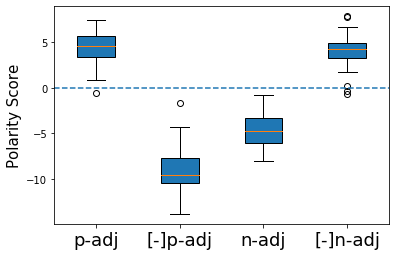

In [70]:
import matplotlib# import pyplot as plt
from matplotlib import rcParams
#plt.style.use('default')
labelsize = 18
# rcParams['xtick.labelsize'] = labelsize
# rcParams['ytick.labelsize'] = labelsize 
matplotlib.rc('xtick', labelsize=18) 
# matplotlib.rc('ytick', labelsize=10) 
# plt.style.use('seaborn-bright')

# plt.style.use('ggplot')
_ = plt.boxplot([pos_token_ps, negation_pos_token_ps, neg_token_ps, 
                 negation_neg_token_ps], patch_artist=True, 
                labels=['p-adj', '[-]p-adj', 'n-adj', '[-]n-adj'])
plt.ylabel('Polarity Score', fontsize=15)
plt.plot([0.5, 4.5], [0, 0], linestyle='--')
# _ = plt.boxplot([pos_token_ps, negation_pos_token_ps], patch_artist=True)
#plt.savefig("imgs/sst_gru_polarity_score_negate_adjective.pdf", bbox_inches='tight', dpi=900)